# Genomics Mapping Project 
### Albane Flocon, Théo Blanc, Livia Colucci 

In the context of the Omics2 - Génomique course, the students developed an algorithm that is able to map short sequences, the reads, on a reference genomic sequence. 

## 0. Preliminary operations

In this section we will be uncompressing the input data, importing the libraries and prepare the data to employ them in the code.

In [ ]:
# terminal operations
!pip install biopython
!gunzip GCF_000002765.5_GCA_000002765_genomic.fna.gz
!gunzip single_Pfal_dat.fq.gz

     |████████████████████████████████| 2.3 MB 15.6 MB/s 


In [53]:
# Libraries import
import numpy as np
import matplotlib as plt
import Bio
import time
import statistics

In [54]:
# Lecture of the given files
from Bio import SeqIO
genome = list(SeqIO.parse("GCF_000002765.5_GCA_000002765_genomic.fna", "fasta"))
reads = list(SeqIO.parse("single_Pfal_dat.fq", "fastq"))

In this project, we will write an algorithm to treat the data *single_Pfal_dat* to obtain the desired results. The aim of this algorithm is on one hand to be able to determine if a word (short DNA sequence) is in a text (genome), to find its position and how many occurences are present in the genome. On the other hand, given a position and a length, the algorithm must be able to hand to word requested.

 
The first step will be that of defining the functions that we will employ, then we will apply them. Finally we will explain our croncrete experimental protocol to test our code with the data. For each defined function the execution time is computed. As the execution time depends on the system occupation, we will run the code multiple times with a for loop and calculate median and standard deviation of the execution time. 

## 1. Algorithm

For this project, the text we be working on is a genome. It implies a very large amount of data (up to 10^9 character) and a short alphabet (A,C,G,T). To search for a short DNA sequence in this large text, naive search is out of range (memory space and compute time). To answer the request, we developped an algorithm using Burrows Wheeler Transform on separated parts of the genome and the LF-index.

### 1.1 BWT file construction

The first functions we define are those that compute the Burrows Wheeler Transform. \
Such functions are `suffix_list`, that computes the list of suffixes of a given string, `suffix_table`, that employs the `suffix_list` function to compute the table of suffixes of a given string, and finally the `BWT_suffix_table`, that computes the Burrows Wheeler Transform of a given string by exploiting the calculation of its suffix table. \
These functions will be exploited to compute the Burrows Wheeler Transform of the genome and, more specifically, of its chromosomes. Unluckily, the genome's chromosomes are too big for the BWT to be performed directly, thus we had to cut them into smaller strings. After various tests, we decided to cut the chromosomes into "pieces" of 150000 characters. On the one hand this was a good choice as it allowed us to compute the BWT and it shortened the execution time of our algorithm. On the other, as the chromosomes are different in terms of length, the last chromosome "piece" has a length that is smaller than 150000 characters and different from one chromosome to another, which is a great desadvantage of our choice.


In [1]:
# Complexity: o(n^log(n)) avec n=len(T)
def suffix_list(T):
    """
    Compute the suffix list
    
    Args:
        T (str): string
    
    Return:
        list of strings: suffix list
    """
    suffix_list = [T[i:] for i in range(len(T))]
    sorted(suffix_list,reverse=True)
    return suffix_list

In [56]:
# Complexity: o(n^log(n)) avec n=len(T)
def suffix_table(T):
    """
    Compute the suffix table
    
    Args:
        T (str): string
    
    Return:
        list of tuples (suffix,location): suffix table
    """
    suffix_list = [T[i:] for i in range(len(T))]
    suffix_table = sorted((e,i) for i,e in enumerate(suffix_list))
    return suffix_table

In [57]:
# Complexity: o(n) avec n=len(T)
def BWT_suffix_table(T,end_of_string="$"):
    """
    Compute the BWT from the suffix table
    
    Args:
        T (str): string
        end_of_string (char): end of string character to append
    
    Return:
        bwt (str): BWT
    """
    T += end_of_string
    ST = suffix_table(T)
    bwt = ""
    for s,i in ST:
        bwt += T[i-1]
    return(bwt)

In [58]:
# Complexity: o(n*m^2) avec n= len(genome) et m=x
# Execution time: almost 4-5 hours.

def list_bwt(genome):
    """
    Cut each chromosomes in 150000 pieces
    Apply 'BWT_suffix_table' on each piece
    Create a file containing all the BWT indexed as ' >chromosome n°  partie n° ' 
    
    Args:
        genome: sequence of the genome in fasta format

    """
    fichier=open("bwt.fasta","a")
    for i in range(0,len(genome)):
        x=len(genome[i])//150000
        for j in range(0,x):
            fichier.write('>chromosome '+ str(i+1) + ' partie ' + str(j+1))
            fichier.write('\n'+str(BWT_suffix_table(genome[i].seq[j*150000:(j+1)*150000-1].upper()))+ '\n')
        fichier.write('>chromosome '+ str(i+1) + ' partie ' + str(x+1))    # last piece of the chromosome
        fichier.write('\n'+str(BWT_suffix_table(genome[i].seq[x*150000:len(genome[i].seq)].upper()))+ '\n')
    fichier.close()

This indexation of the genome is very long to run! So to make the execution of our algorithm easier, we choose to copy all the BWTs in a file, so that the next functions will just have to read the file. We also choose to work with only upper letters, so that the aphabet order will be respect everywhere. 

### 1.2 Pattern Matching

We want now to be able to find a word w of length k in the text. In our case, the text is really big (up to 10^9 characters). We already indexed the genome through the BWT transform, so we will use this indexation and its properties to search the occurences the word in the text and theirs positions if present. 

We settle for a method using the principle of LF-mapping without computing the first column of the BWT table. For that we use the fact that the i-th occurrence of a character c in the last column of BWT table and i-th occurrence of a character c in the first column are the same occurrence in the BWT. Using the function `last2first`, we can navigate from the index of the last column to the index of the first column. Furthermore, the first column is (lexico) ordered, so it makes the search easier. 

The function `pattern_matching` takes as argument the pattern to search and the file with all the BWT transform, and returns the position of all the pattern's occurences. `pattern_matching` iterate through each BWT of the file, and to each :
- Find the index of the first and last occurence of the pattern in the BWT with the use of repeated `get_first_occurence` and `last2first` functions ;
- Compute the BWT inverse with function `efficient_bwt_inverse` ; 
- Iterate from the first to the last occurence index, to find the position of the pattern in the BWT inverse with `find_position`. 


In [59]:
# Complexity: o(n) avec n=len(S)
def occurrence_indexer(S):
    
    """
    Indexes the text sent in input
    
    Args:
        S (str): text we want to index
    
    Return:
        k (list): list of indexes
    """
    
    K = []
    last_index = {}
    for s in S:
        if s not in last_index: 
            last_index[s] = 0
        K.append(last_index[s])
        last_index[s] += 1
    return(K)

In [60]:
# Complexity: o(1)
def last2first(counts,k,X):
    """
    Allows for the First Last property of the Burrows Wheeler Transform to be exploited as it ...
    Args:
        counts : nb of occurence per character of the alphabet 
        X (char): character 
        k (int): index of the character X in the last column of "BWT table"
    Return:
        k (int): index of the X occurence in the first column
    """
    return k + sum([counts[char] for char in counts if char < X])

In [61]:
# Complexity: o(n) avec n=len(L)
def get_first_occurrence(L,X):
    """
    Get the index of the first occurence of X in the text L
    
    Args:
        L (str): text or sequence 
        X (char): character 
    
    Return:
        i (int): index of the first X in L
    """
    
    for i,l in enumerate(L):
        if l == X:
            return(i)

In [70]:
# Complexity: o(n) avec n = len(bwt)
def efficient_inverse_BWT(bwt,end_of_string="$"):
    """
    Inverse the BWT
    
    Args:
        bwt (str): bwt of a string T
        end_of_string (char): character at this end of the sequence, always $
    
    Return:
        S (str): BWT^{-1} of bwt
        R (list): list of occurrence indexes of the inverse BWT
    """    
    K = occurrence_indexer(bwt)
    counts = Counter(bwt)
    G=bwt
    X = G[0]
    k = K[0]
    R=[]
    S = end_of_string
    while X != end_of_string:
        S = X+S
        j = last2first(counts,k,X)
        X = G[j]
        R.append(k)
        k = K[j]    
    return(S,R)

In [84]:
# Complexity: o(i+k)

def find_position(X, S, R, K, r, s):
    """
    This function finds the position of a word in a text.
    
    Args:
        X (char): first letter of the pattern
        S (str): result of the inverse BWT
        R (list): list of occurrence indexes of the inverse BWT
        K (list): list of occurrence indexes of the BWT
        r (int): first position of the word occurrence
        s (int): last position of the word occurrence                           
    
    Return:
        res (str): list of positions of the word   
    """
 
    res = ""
    for index_mot in range(r,s + 1):
        j=0
        while  X!= S[j] or R[len(R)-j-1]!=K[index_mot]:
          #print(X,S[j],R[len(R)-j-1],K[pos[len(pos)-1]])
          j+=1
        res+= ("At the position:"+ str(j + 1)+"\n")
    return res

In [65]:
from collections import Counter

def pattern_matching_BWT(file_name,pattern):
    """
    Search a patter in a String using the BWT contained in a file
    
    Args:
        file_name (str): name of the file containing BWT sequences
        pattern (str): sequence of DNA = reads
    
    Return:
        res (str): return position of each pattern found in the genome    
    """
    
    # Read the file to stock all the BWTs
    file_bwt = open(file_name, "r")
    list_bwt=[]
    for record in SeqIO.parse(file_bwt, "fasta"):
        list_bwt.append(record)
    
    # On each BWT, research of the pattern:
    res = " Research results: \n"
    
    for index,bwt in enumerate(list_bwt):
        K = occurrence_indexer(bwt.seq)
        counts = Counter(bwt.upper())
        e = 0
        f = len(bwt.seq.upper())
        i = len(pattern) - 1
        pos=[]
        
        while e < f and i >= 0:
            X = pattern[i].upper()
            
            # Index of first occurence of X in last column of BWT table
            first_occurence_in_bwt_ef = get_first_occurrence(bwt[e:f].seq.upper(),X)
            if first_occurence_in_bwt_ef is None:
                break
            else:
                 r = first_occurence_in_bwt_ef+e
            
            # Index of last occurence of X in last column of BWT table
            last_occurence_in_bwt_ef = get_first_occurrence(bwt[e:f][::-1].seq.upper(),X)
            if last_occurence_in_bwt_ef is None:
                break
            else:
                s = f-last_occurence_in_bwt_ef-1
        
            # Use the property Last-First colunm of BWT table
            e = last2first(counts,K[r],X)
            f = last2first(counts,K[s],X)+1
            i -= 1
            pos.append(r) 
            
        
        if i<0 :
            S,R = efficient_inverse_BWT(bwt)     # compute BWT{-1}
            S=S.upper()
            X=pattern[0]
            res += " In "  + bwt.description + " : " +  str(i<0) + "\n  "
            res += find_position(X, S, R, K, r, s)     # Find positions of all pattern from r to s
            
    file_bwt.close()
    return res

With this algorithm, we do not care about the cut of chromosome. So if the read we search is at the intersection bewteen 2 BWT, our code will not find it. There would be a way of doing it, by giving a particular lenght (lenght(word)) to the search so that at the end of the part, it will search the newt part to see if it matches. Unfortunately, we could not to it due to space and time problems. 

This algorithm has a quite short run time, but use quite a lot of space. 

### 1.3 Extraction of a string 

The last function we define is the `extract_string`, that allows us to extract a word of a given length at a given position in a test. \
This function can be employed to verify if our Mapping algorithm gives the correct position of the read in the genome: after having found the position of the read in the genome we can apply the `extract_string` function to extract a word of the same length of the read from the genome at the position indicated by the Mapping algorithm.
We find a compute time really low. 

In [67]:
# Complexity: o(i+k)
def extract_string (text, i, k):
    """
    Extracts the word of length k present at position i in the text.
    
    Args:
        text (str): string from which the word will be extracted.
        i (int) : position of the word that will be extracted.
        k (int) : length of the word that will be extracted.
    
    Return:
        out_string (str): extracted word.
    """
    out_string = text [i : i + k]
    return (out_string)

# Execution time measure

"""
measures = []
for i in range(100):
    start = time.time()
    
    S = extract_string(genome.seq, 1, 640850)
    
    end = time.time()
    measures.append(end - start)

mean = statistics.mean(measures)
stdev = statistics.stdev(measures)

print('Execution time :')
print(f' - Mean : {mean:.1}ms')
print(f' - Standard deviation : {stdev:.1}ms')
"""

"\nmeasures = []\nfor i in range(100):\n    start = time.time()\n    \n    S = extract_string(genome.seq, 1, 640850)\n    \n    end = time.time()\n    measures.append(end - start)\n\nmean = statistics.mean(measures)\nstdev = statistics.stdev(measures)\n\nprint('Execution time :')\nprint(f' - Mean : {mean:.1}ms')\nprint(f' - Standard deviation : {stdev:.1}ms')\n"

## 2. Function testing

We will now test our functions on the datas given to see results. For each read, we test the reverse complement to be sure the pattern is in the genome. At the end of this section, you will find at screenshot of the data open on Galaxy, with the position of each read. 

In [68]:
print(pattern_matching_BWT("bwt2.fasta",str(reads[0].seq)))
print("For the reverse complement : ")
print(pattern_matching_BWT("bwt2.fasta",str(reads[0].seq.reverse_complement())))

 Research results: 

For the reverse complement : 
 Research results: 



If we test our function on the first read of the file, we don't get any match. It is most likely because this read is located at the intersection between two cuts of the chromosomes.
Testing the time it takes for executing this test give us a mean of 3e01ms which seems faster than it execute. Executing it take less than a minute but it still feel like a few seconds are necessary.

In [85]:
print(pattern_matching_BWT("bwt2.fasta",str(reads[100000-98582].seq)))
print("For the reverse complement : ")
print(pattern_matching_BWT("bwt2.fasta",str(reads[100000-98582].seq.reverse_complement())))

 Research results: 
 In chromosome 1 partie 1 : True
  At the position:36

For the reverse complement : 
 Research results: 



When we test this read, the first one on the image below, we can see that it does find it at the rigth position.

In [86]:
print(pattern_matching_BWT("bwt2.fasta",str(reads[2].seq)))
print("For the reverse complement : ")
print(pattern_matching_BWT("bwt2.fasta",str(reads[2].seq.reverse_complement())))

 Research results: 
 In chromosome 1 partie 4 : True
  At the position:21738

For the reverse complement : 
 Research results: 



This one is the third read of the file and it is found somewhere on the 4th part of the first chromosome. We can test ourself wether or not it is the rigth position by extracting the word that is at this position :

In [88]:
genome=[]
file_bwt = open("genome.fasta","r")
for record in SeqIO.parse(file_bwt, "fasta"):
    genome.append(record)

This file contain our genome cut in the same way we cut it for the BWT.

In [89]:
print(str(reads[2].seq))
print(extract_string(str(genome[3].seq), 21738-1, len(reads[2].seq)))

TCATGATTTACATATATTTGTAAAACATATATAATCTGTCCAGACATATTATATAATTGATAATATAATATATATATATATATATAAATTATTACTTCTC
tcatgatttacatatatttgtaaaacatatataatctGTCCagacatattatataattgataatataatatatatatatatatataaattattacttCTC


We can see that it matches.

In [90]:
print(pattern_matching_BWT("bwt2.fasta",str(reads[100000-97243].seq)))
print("For the reverse complement : ")
print(pattern_matching_BWT("bwt2.fasta",str(reads[100000-97243].seq.reverse_complement())))

 Research results: 

For the reverse complement : 
 Research results: 
 In chromosome 1 partie 1 : True
  At the position:49



For this one, we tested the second read from the image below and we get a match at the rigth position for the reverse complement.

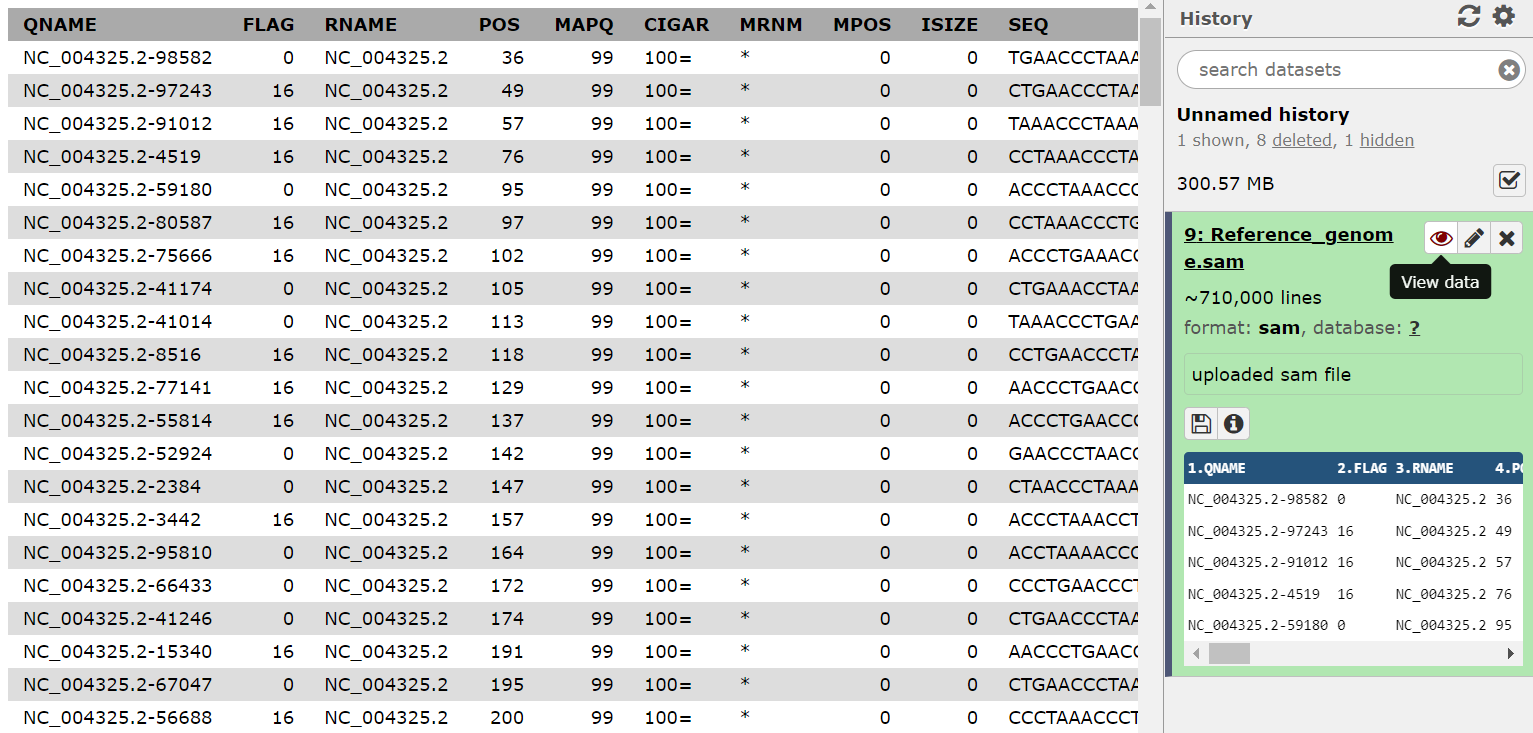

To conclude this testing, it seems our function works perfectly fine as long as the read isn't located on one of our arbitrary cut. Other than that, running an individual test doesn't take all that long but running it on all of the reads would probably take a few hours so we didn't do it.

## 3. Experimental protocol

The aim of this project is to develop a strategy to map short sequences gather by sequencing on a genome, given that sequencing errors and diverse mutations may occurs. With our algorithm, each mutation will kill the pattern matching function, returning either nothing or a false position/another sequence. It would be impossible to find the real position. To answer this problem, we could map not this entire read, but kmers of the read and statistically chose the positions over some threeholds. 

To analyse all the reads we were given, a few steps were needed. First the BAM file (Binary Alignement Map) had to be convert to SAM. For that, we used GALAXY website. Then we "cleaned" the dataset, to avoid having poor quality sequences and contaminated sequences (due to sequencing). We used Trimmomatic tools. It deletes extremities (often poor quality) and poor quality reads (bad scores), filtered sequencies (not here because all have the same lenght)... This method is useful to have a clean mapping, because any mutations cause a delocalisation. 

Finally, we use our algorithm to map the reads to the genome given. Due to time and space place, we could not run on all the reads, but in the protocol we must run it on the entire set. 

So now that all the reads are mapped on the genome, we must identify the mutation and their origin. 
For example, if a middle k-mer have occurences far below than the correctly positioned k-mers, then it is propably an error of sequencing. In any case, the number of k-mers that are not correctly positioned as well as the positioning of the k-mers at the ends will allow define, by a simple calculation, the origin of the variation (substitution, insertion, deletion) in the middle of the kmer. 
But if the mutation or error occurs towards one of the ends from the read, then depending on whether the number of correctly located k-mers is significant or not it will be possible or not to correctly locate the read. We could identify whether it is a variation of biological origin or an error, however, it will not be possible to diagnose the variation more precisely.

In short, to control ground data by mapping them to a genome, we must be able to check for mutations. By cleaning the dataset and mapping k-mers of reads, identification of mutations and their type can be done, under a certain threshold. The clean up of the dataset is a major factor in the quality of the results. 

## 4. Conclusions and future perspectives

In conclusion, we were able to develop a Mapping algorithm that allows us to:

* Research a word (the read) into a text (the genome);
* Research the complementary inverse of such word into the text;
* Identify how many times such word appears in the text, at which positions and on which strand;
* Find a word of a given length at a given position in a given text.

Due to time reasons, we were not able to:

* Manage the reads that fall between two chromosomes' "pieces";
* Analyse the possibility of mutations, which could have been done through an Alignement.

These two points thus remain as future perspectives to further improve our Mapping algorithm and our protocol to identify mutations.